# LLM 架构

---

大型语言模型（LLM）代表了现代人工智能系统的一次飞跃，综合运用自然语言处理（NLP）、Transformer、分布式计算等多项技术。尽管这些组件都是现代 LLM 的关键构成，但 Transformer 无疑是推动 LLM 崛起的最重要技术突破。此阶段并不要求深入掌握 Transformer 的全部细节，但理解现代 LLM 的核心流程至关重要：

* **分词（Tokenization）：** 将文本转换为机器可理解的数字
* **处理（Processing）：** 让模型判断文本中的"重要性"
* **生成（Generation）：** 通过解码策略生成文本

## 本课程的结构？

**《[LMP-C01] LLM Engineer (Professional)**》课程采用独特设计，为您构建一个*虚构情境*，并以您为主角。课程中的示例、实验与挑战都环绕此情境展开。您将以主角身份完成这些挑战，从而掌握成为一名**LLM Enginner**所需的全部能力。

## 故事背景

您创立了自己的初创公司，正在打造一款名为 **TaskFriend** 的新应用——一位帮助用户管理日常任务、安排优先级并优化时间的 AI 助手。随着生成式 AI 技术的不断发展，您不断思考如何将 AI 更好地融入产品。近期的一项用户调研带来不少启发，其中一条反馈尤其引人注意：*`"When I log tasks or new ideas, I often find myself stuck in a loop on deciding how to proceed or what to do next. What does the TaskFriend team do when they find themselves in a situation like this?"`* 这激发了您一连串的想法，最终得出一个结论。

您的目标：让 AI 能够理解诸如 `"How do I organize my week?"` 或 `"What’s the best way to study for exams?"` 这样的自然语言问题。

在本章中，我们将围绕以下复杂问题的处理思路开展学习：

`"I need to finish a report due tomorrow but also want to go to the gym to keep fit. I'd like to do both. What should I do?"`

## 学习目标

* 理解 LLM 如何处理与效率相关的咨询
* 构建任务优先级机器人
* 识别并规避伦理风险（如排程导致的过劳风险）

## 初始化环境

### 配置 API Key

在任何笔记本开始工作前，我们都需要加载 [Model Studio 的 API Key](https://modelstudio.console.alibabacloud.com/?tab=globalset#/efm/api_key)，以便调用本课程中将持续使用的 Qwen 系列模型接口。

> 如不清楚如何获取 **Model Studio** API Key，请参阅 `00 Setting Up the Environment` 文件。

In [1]:
# Load Model Studio API key
import os
from config.load_key import load_key
load_key(
    confirmation=False
)

Detected existing API key: sk-8...2716
Auto-confirmation enabled. Using existing API key.


### 配置 LLM 客户端

我们将通过 DashScope 提供的、兼容 OpenAI 协议的接口来与 Qwen 模型（以及课程中会使用的其他模型）进行交互。

注意：如果是国际版 Model Studio 用户，请将以下代码中的 `base_url` 参数设置为 `https://dashscope-intl.aliyuncs.com/compatible-mode/v1`。


In [2]:
import os
from openai import OpenAI
import logging

logging.getLogger().setLevel(logging.ERROR)

client = OpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1/",
)

## 体验 TaskFriend 聊天机器人

### LLM 的响应方式

LLM 可以通过两种模式给出回答：流式（streaming）与非流式（non-streaming）。

我们先从非流式模式入手。在这种模式下，模型需要接收完整的输入后才会生成响应，适用于对实时交互要求不高的场景。例如您在搜索引擎输入查询时，搜索引擎通常会以非流式方式处理请求并返回结果。对于大多数用户而言，这样的延迟可以接受，因此实时性并非首要考虑。

现在，我们来测试一下聊天机器人在非流式模式下对简单问题的响应表现：

In [3]:
# User query
query = "请简单介绍一下你自己"

# System prompt
system_prompt = "你是 TaskFriend，一名帮助用户管理日常任务、设置优先级并优化时间安排的贴心中文 AI 助手。"

In [4]:
# Non-streaming mode response
def get_qwen_response(query, system_prompt, temperature, top_p):
    response = client.chat.completions.create(
        model="qwen-plus",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": query}
        ],
        temperature=temperature,
        top_p=top_p,
        stream=False
    )
    return response.choices[0].message.content

response = get_qwen_response(query, system_prompt, temperature=0.7, top_p=0.8)
print(f"Query: '{query}'")
print(f"=" * 50 + "\n")
print(response)

Query: '请简单介绍一下你自己'

你好呀！我是 TaskFriend，你的贴心任务小助手～ 🌟  
我最擅长帮你管理日常任务、规划时间、设置优先级，让你的生活更有条理、更高效。无论是工作待办、学习计划，还是生活琐事，我都会耐心倾听，和你一起拆解目标、合理安排时间。

我会用清晰又温暖的方式和你沟通，偶尔还会给你一点鼓励和提醒，就像一个真正的朋友一样 💬✨  
有我在，再也不怕事情太多记不住、做不完啦！

随时告诉我你想做什么，我们一起搞定它！💪  
现在有什么我可以帮你的吗？😊


您是否注意到，从运行代码到收到回答之间存在短暂延迟？这正是非流式模式的典型表现：在完整生成答案之前，模型不会返回任何输出。对于简短问答而言，这样的延时尚可接受，但若请求内容较长，例如让 LLM 编写完整方案，等待时间就会显著增加，从而影响终端用户体验。

LLM 的一项重要优势在于流式模式，它允许模型在接收输入的同时分段输出结果。这样既能提升响应速度，也营造出更“人性化”的体验，仿佛正在与实时对话的伙伴互动。

若要在 Qwen 中启用流式模式，我们需要在函数中加入 `stream=True`，并按照数据块处理返回内容：

In [5]:
# Streaming mode response
def get_qwen_stream_response(query, system_prompt, temperature, top_p):
    response = client.chat.completions.create(
        model="qwen-plus",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": query}
        ],
        temperature=temperature,
        top_p=top_p,
        stream=True
    )
    
    for chunk in response:
        content = chunk.choices[0].delta.content
        if content:  # Skip empty chunks
            yield content

response = get_qwen_stream_response(query, system_prompt, temperature=0.7, top_p=0.8)
print(f"Query: '{query}'")
print(f"=" * 50 + "\n")
for chunk in response:
    print(chunk, end="")

Query: '请简单介绍一下你自己'

你好呀！我是 TaskFriend，你的贴心任务小助手～ 🌟  
我最擅长帮你管理日常任务、规划时间、设置优先级，让你的生活更有条理、更高效。无论是工作待办、学习计划，还是生活琐事，我都会耐心帮你整理，提醒你重要事项，甚至还能根据你的时间安排给出合理建议哦！

简单来说，我就是那个默默在背后支持你、陪你把“要做的事”变成“已完成”的好朋友 ✅  
有什么需要帮忙的，随时告诉我吧！😊

# 分词：让文本变成数字

---

机器真的能听懂人类在说什么吗？与我们不同，机器并不能直接理解自然语言。倘若让其自行发展语言体系，结果很可能与人类预期大相径庭。一个著名案例是 Facebook 人工智能研究院（FAIR）在 2017 年进行的实验，他们训练了一套 AI 系统，并观察其生成的“语言”……

总的来说，机器并不擅长天生理解语言，但它们极善于处理数字。因此，LLM 处理任何查询的第一步，便是通过 **分词（tokenization）** 将文本拆解并转化为数字。分词会把句子拆分成一个个 **词元（token）**，这些词元就是 LLM 接收的原始输入。

## 什么是词元？

**词元** 是 LLM 能够理解的最小意义单位，可以是：

* 一个**完整单词**（如 "deadline"）
* 一个**子词**（如 "un" + "happiness"）
* 一个**符号**（如 "。"、"？"）




In [6]:
# User query
query = "I have a report due tomorrow, but I want to go to the gym to avoid burnout."

In [7]:
import warnings
from transformers import AutoTokenizer
from functions.safe_token_str import safe_token_str
from functions.token_table import create_token_table

warnings.filterwarnings("ignore")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "Qwen/Qwen-7B", 
    trust_remote_code=True,
    use_fast=True
)

# Tokenize input string
tokens = tokenizer.tokenize(
    query,
    allowed_special=set(),  # Treat all text as normal text
    disallowed_special=()    # Don't raise errors for special tokens
)

# Convert tokens to strings (handle bytes if necessary)
tokens = [t.decode('utf-8') if isinstance(t, bytes) else t for t in tokens]

# Get token IDs
token_ids = tokenizer.encode(
    query,
    allowed_special=set(),
    disallowed_special=()
)

# Verify token-ID alignment
if len(tokens) != len(token_ids):
    min_len = min(len(tokens), len(token_ids))
    tokens = tokens[:min_len]
    token_ids = token_ids[:min_len]

# Display tokenization results in a styled table
print(f"Query: '{query}'")
print(f"=" * 50 + "\n")
print("Tokenization Results:")
create_token_table(tokens, token_ids)

Query: 'I have a report due tomorrow, but I want to go to the gym to avoid burnout.'

Tokenization Results:


,Pos#,Token,Token ID
0,1,'I',40
1,2,' have',614
2,3,' a',264
3,4,' report',1895
4,5,' due',4152
5,6,' tomorrow',16577
6,7,"','",11
7,8,' but',714
8,9,' I',358
9,10,' want',1366


### 重复词元 ID 的意义

每个词元都有唯一的 ID——也就是说，同一个词元在任何位置都会对应同一个 ID。在上一示例中，我们看到多个词元共享**相同的词元 ID**。这恰恰是 LLM 中**最基础却经常被忽视的概念之一**。我们一起来看看，为何相同的词元会拥有相同的 ID，以及这种重复对于语义理解有何重要作用。

```mermaid
graph LR
A[Token ' to'] --> B{Vocabulary}
B --> C[ID 311]
D[Another ' to'] --> B
E[' report'] --> B
B --> F[ID 1895]

```

这是分词的一个**基本规律**：

* 每次出现完全相同的词元，都会映射到完全相同的 ID
* 因此带空格的 `' to'` 总是映射到同一个 ID
* 但不带空格的 `'to'` 则不是同一个词元（ID 不同）

### 重复 ID 如何构建语义理解

1. **模式识别引擎**
    
    当同一词元 ID 多次出现时，模型会捕捉到有意义的模式：
    
    `# 用户查询: "I need to finish... want to go to the gym..."`
    
    `token_ids = [..., 311, ..., 311, ..., 311, ...]  # 都是 ' to' 词元`
    
    **模型学到的内容：**

    * 当 ID 311（' to'）在一句话中出现 3 次 → 极可能是任务列表
    * 模式： [ACTION] to [TASK] → [ACTION] to [TASK] → [ACTION] to [TASK]
    * TaskFriend 便能据此识别 "need to finish"、"want to go"、"like to do" 等任务序列
    
2. **注意力机制的“燃料”**
    
    重复的词元 ID 为 Transformer 的注意力机制提供动力：
    
    ```mermaid
    graph LR
    A[' to' ID 311] --> B[Attention]
    C[' to' ID 311] --> B
    D[' to' ID 311] --> B
    B --> E[Pattern: Task Sequence]
    
    ```
    
    注意力机制会学习到：
    
    > “当我连续看到多个 ID 311 的词元时，要重点关注后面的内容——它们很可能是任务列表。”
    
    正是借助这种注意力机制，TaskFriend 能理解 "need to finish"、"want to go" 和 "like to do" 形成的任务序列模式，并据此触发优先级判断逻辑。

## 子词分词及更多

早期的自然语言处理系统采用基于单词的分词方式，但这种方法在以下场景下表现不佳：

* 罕见词（如 "floccinaucinihilipilification"）
* 复合词（如 "unhappiness"、"burnout"）
* 拼写错误（如 "teh"，应当对应 "the"）

您可能也注意到，在前一个示例中，分词结果会保留单词前面的空格（或称“空白字符”）。既然我们可以根据空格准确拆分句子，为何还需要这么做呢？

In [8]:
# User query
query = "I have a report due tomorrow, but I want to go to the gym to avoid burnout."

In [9]:
print("Whitespace vs Qwen Tokenization Strategy")
print("="*60)

# Whitespace Tokenizer
ws_tokens = query.split()

# Dynamically find problem tokens (compare tokens to Qwen's tokenizer)
problem_tokens = []
for ws_token in ws_tokens:
    # Check how Qwen tokenizes this single whitespace token
    qwen_subtokens = tokenizer.tokenize(
        ws_token,
        allowed_special=set(),
        disallowed_special=()
    )
    # If Qwen splits it into multiple tokens, it's a problem
    if len(qwen_subtokens) > 1:
        problem_tokens.append(ws_token)

print("\n🔤 Whitespace Tokenization (naive approach):")
print(f"    Tokens: {ws_tokens}")
print(f"    Token count: {len(ws_tokens)}")
print(f"    Problem tokens: {problem_tokens}")

# 2. Qwen Tokenizer
qwen_tokens = tokenizer.tokenize(
    query,
    allowed_special=set(),
    disallowed_special=()
)
qwen_tokens = [safe_token_str(t) for t in qwen_tokens]

# Show subword structure, i.e. 'burnout' → 'burn' + 'out' 
actual_subwords = []
for token in qwen_tokens:
    # For tokens with leading space, show the actual word components
    if token.startswith(' ') and len(token) > 1:
        # Tokenize the word WITHOUT leading space to see true subwords
        word = token.strip()
        subwords = tokenizer.tokenize(
            word,
            allowed_special=set(),
            disallowed_special=()
        )
        subwords = [safe_token_str(t) for t in subwords]
        if len(subwords) > 1:
            actual_subwords.append(f"{token} → {subwords}")
        else:
            actual_subwords.append(token)
    else:
        actual_subwords.append(token)

print("\n🤖 Qwen Tokenization (byte-level BPE):")
print(f"    Tokens: {qwen_tokens}")
print(f"    Token count: {len(qwen_tokens)}")
print(f"    True subword structure: {actual_subwords}")

# 3. The Critical Difference
print("\n" + "=" * 50)
print("Why Tokenization Methods Matter")
print("=" * 50)
print(f"1. Whitespace fails on {len(problem_tokens)}/{len(ws_tokens)} tokens ({len(problem_tokens)/len(ws_tokens)*100:.0f}% failure rate!):")
for token in problem_tokens:
    qwen_subtokens = [safe_token_str(t) for t in tokenizer.tokenize(token, allowed_special=set(), disallowed_special=())]
    print(f"   - '{token}' → {len(qwen_subtokens)} tokens: {qwen_subtokens}")

print(f"\n2. Real-world consequence:")
print(f"   Whitespace: {len(problem_tokens)}/{len(ws_tokens)} tokens problematic ({len(problem_tokens)/len(ws_tokens)*100:.0f}% failure rate!)")
print(f"   Qwen: 0/{len(qwen_tokens)} tokens problematic (100% coverage)")

Whitespace vs Qwen Tokenization Strategy

🔤 Whitespace Tokenization (naive approach):
    Tokens: ['I', 'have', 'a', 'report', 'due', 'tomorrow,', 'but', 'I', 'want', 'to', 'go', 'to', 'the', 'gym', 'to', 'avoid', 'burnout.']
    Token count: 17
    Problem tokens: ['tomorrow,', 'gym', 'burnout.']

🤖 Qwen Tokenization (byte-level BPE):
    Tokens: ['I', ' have', ' a', ' report', ' due', ' tomorrow', ',', ' but', ' I', ' want', ' to', ' go', ' to', ' the', ' gym', ' to', ' avoid', ' burn', 'out', '.']
    Token count: 20
    True subword structure: ['I', ' have', ' a', ' report', ' due', " tomorrow → ['tom', 'orrow']", ',', ' but', ' I', ' want', ' to', ' go', ' to', ' the', " gym → ['g', 'ym']", ' to', ' avoid', ' burn', 'out', '.']

Why Tokenization Methods Matter
1. Whitespace fails on 3/17 tokens (18% failure rate!):
   - 'tomorrow,' → 3 tokens: ['tom', 'orrow', ',']
   - 'gym' → 2 tokens: ['g', 'ym']
   - 'burnout.' → 3 tokens: ['burn', 'out', '.']

2. Real-world consequence:
   Wh

我们可以清楚看到，基于空格的分词策略与 Qwen 的 BPE 分词策略之间存在显著差异。

```mermaid
graph LR
A[Whitespace Tokenizer] --> B[Subword Tokenization]
B --> C[Qwen's Byte-Level BPE]
C --> D[Vectorization]

```

### 关键差异：保留空格 vs. 理解子词

空格分词只是简单地按照空格拆分文本（例如把 "burnout" 当作一个整体），而 Qwen 的方法则同时在两个层面运作：

* **表层：** 保留空格信息，以便精准还原原文
* **语义层：** 通过子词结构理解单词内部的语义关系

#### 可视化双层分词

```mermaid
graph TB
    subgraph Whitespace Tokenizer
        direction TB
        W1["'burnout'"] --> W2["单一词元<br/>(无内部结构)"]
    end
    
    subgraph Qwen's Byte-Level BPE
        direction TB
        Q1["' burned'"] --> Q2["表层词元<br/>(含空格)"]
        Q1 --> Q3["语义结构<br/>burn + out"]
        Q2 --> Q4["精准还原文本"]
        Q3 --> Q5["模式识别"]
    end
    
    W2 -.->|无法处理未知词| Q5
    Q5 --> R["TaskFriend 得以理解：<br/>- 'burned' 与 'burnout' 的关联<br/>- 'time' + 'block' = 提升效率"]

```

Qwen 的分词器不仅仅是拆分文本，它构建了一个双层表示：保留空格确保可以完美复原文本，同时通过子词理解连接语义。这使得 Qwen 在精准处理用户语言的同时，即便用户从未用过某个词，也能通过相关子词推断其含义，例如从 *"burn"* 与 *"out"* 理解 *"burnout"*。

# 向量化与注意力：词元如何获得含义

---

想象您正向朋友倾诉繁忙的日程：

> "I need to finish a report due tomorrow but also want to go to the gym. What should I do?"

朋友不仅能听到这些词语，更能理解 "report due tomorrow" 所代表的**紧迫性**，以及去健身房对身心健康的重要性。他们会权衡两者，为您提出可行建议。

那么，如何让 **TaskFriend** 也做到这一点？我们希望它学会识别关键短语：

* "report due tomorrow"
* "want to go to the gym"

答案就是向量化与注意力机制——它们负责识别核心词元，并将其转换为富含语义的表示。

## 向量空间：意义的承载体

可以把它想象成一片浩瀚的宇宙空间，每个词都有属于自己的坐标。在这片空间里：

* 工作相关词语聚集在一片区域（report、deadline、meeting）
* 健康相关词语形成自己的星群（gym、burnout、wellness）
* 与时间紧迫相关的词语围绕着“紧急”轨道运行（tomorrow、ASAP、deadline）

当 **TaskFriend** 看到 "report due tomorrow" 时，它并不是在处理三个互不关联的词，而是识别出这些向量组合位于“紧急工作”区域。当它看到 "gym to keep fit" 时，也会意识到这组向量位于用户“个人偏好”的语义区域。

> **说明：** 本节演示示例选用 distilBERT，以兼顾模型体量与运行速度。

In [10]:
# User query
query = "I have a report due for tomorrow's meeting, but I want to go to the gym to stay fit."

In [11]:
# Define cluster terms
# These do not affect the results of the model in any way, but serve to help better visualize the vector representations
WORK = ['report', 'task', 'assignment', 'project', 'analysis', 'deadline', 'due', 'submit']
WELLBEING = ['gym', 'exercise', 'workout', 'burnout', 'stress', 'energy', 'balance', 'happy', 'fit']
URGENCY = ['tomorrow', 'today', 'now', 'need', 'must', 'should', 'due', 'immediate', 'urgent', 'soon']

Identifying Key Tokens & Vectorizing Them

Loading language model (distilBERT)... Done ✓ (0.9 seconds)

Analyzing query: 'I have a report due for tomorrow's meeting, but I want to go to the gym to stay fit.'
Processing with attention analysis... Done ✓ (0.4 seconds)

Identifying important task elements... Done ✓ (0.0 seconds)
  1. 'gym' (importance: 1.000)
  2. 'want' (importance: 0.835)
  3. 'stay' (importance: 0.797)
  4. 'go' (importance: 0.789)
  5. 'fit' (importance: 0.787)
  6. 'due' (importance: 0.765)
  7. 'report' (importance: 0.714)
  8. 'to' (importance: 0.682)
  9. 'to' (importance: 0.680)
  10. 'tomorrow' (importance: 0.650)
  11. 'but' (importance: 0.627)
  12. 'the' (importance: 0.616)
  13. 'to' (importance: 0.551)
  14. 'meeting' (importance: 0.549)
  15. 'for' (importance: 0.520)

📊 Visualizing vector map...


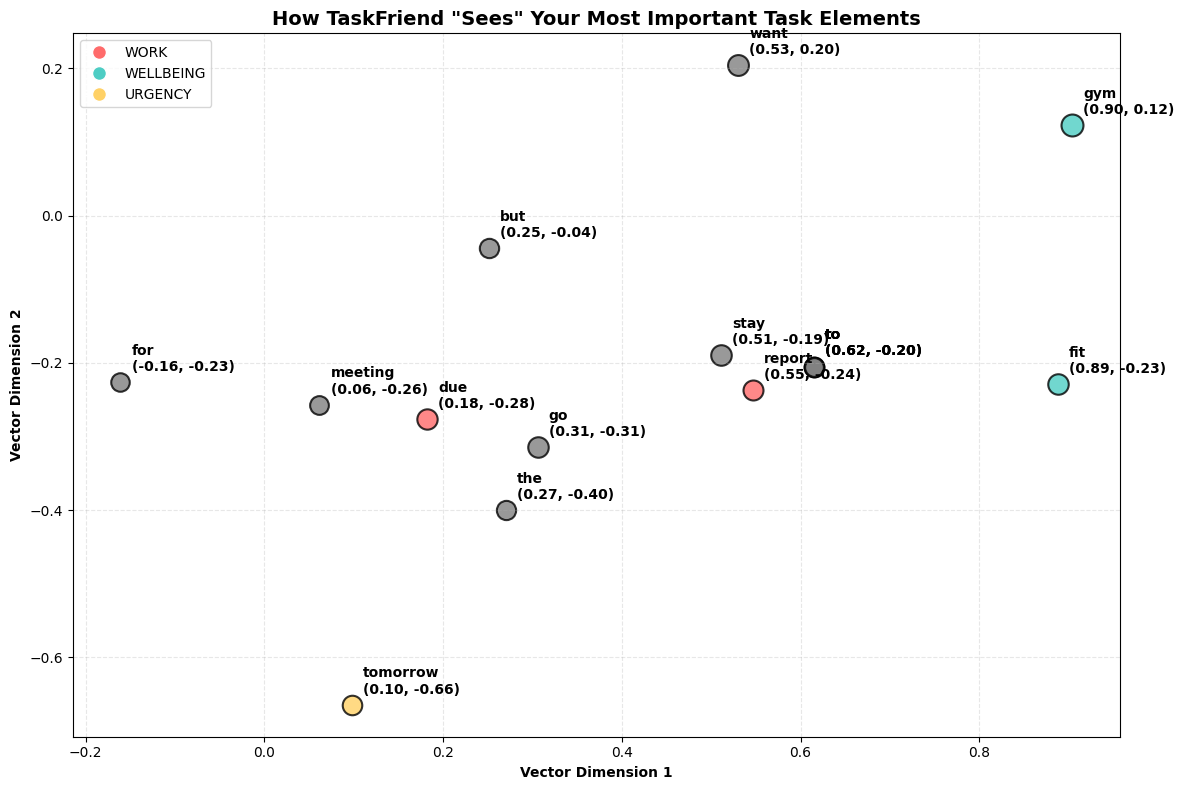

In [12]:
import time
import torch
import numpy as np
from transformers import AutoModel
from functions.vector_visualization import visualize_task_elements  # Import visualization function

print("Identifying Key Tokens & Vectorizing Them")
print("="*50)

# Load the model
print("\nLoading language model (distilBERT)...", end="", flush=True)
start_time = time.time()

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased", output_attentions=True)
model.eval()

load_time = time.time() - start_time
print(f" Done ✓ ({load_time:.1f} seconds)")

# Get embeddings AND attention weights
print(f"\nAnalyzing query: '{query}'")
print("Processing with attention analysis...", end="", flush=True)
start_time = time.time()

with torch.no_grad():
    inputs = tokenizer(query, return_tensors="pt")
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[0].numpy()
    attentions = outputs.attentions

load_time = time.time() - start_time
print(f" Done ✓ ({load_time:.1f} seconds)")

# Extract tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# 1. FILTER: Remove special tokens and subwords
meaningful_indices = [i for i, token in enumerate(tokens) 
                     if token not in ['[CLS]', '[SEP]'] and 
                     not token.startswith('##') and 
                     len(token) > 1]
meaningful_tokens = [tokens[i] for i in meaningful_indices]
meaningful_vectors = embeddings[meaningful_indices]

# 2. LET THE MODEL DECIDE: Use attention to identify key tokens
print("\nIdentifying important task elements...", end="", flush=True)
start_time = time.time()

# Calculate attention importance scores
attention_scores = np.zeros(len(meaningful_tokens))
for layer_attention in attentions:
    avg_heads = layer_attention[0].mean(dim=0).numpy()
    
    for idx, orig_pos in enumerate(meaningful_indices):
        attention_to_token = avg_heads[:, orig_pos]
        meaningful_attention = [attention_to_token[i] for i in meaningful_indices if i != orig_pos]
        
        if meaningful_attention:
            attention_scores[idx] += np.mean(meaningful_attention)

# Normalize scores
attention_scores = attention_scores / np.max(attention_scores) if np.max(attention_scores) > 0 else attention_scores

# Get top 15 most important tokens according to attention
top_indices = np.argsort(attention_scores)[::-1][:15]
key_tokens = [meaningful_tokens[i] for i in top_indices]
key_vectors = meaningful_vectors[top_indices]
key_scores = attention_scores[top_indices]

load_time = time.time() - start_time
print(f" Done ✓ ({load_time:.1f} seconds)")

# Print the model's selected key tokens and their importance
for i, (token, score) in enumerate(zip(key_tokens, key_scores)):
    print(f"  {i+1}. '{token}' (importance: {score:.3f})")

# Visualize vector map
print("\n📊 Visualizing vector map...")
visualize_task_elements(
    key_tokens, 
    key_vectors, 
    key_scores,
    work_terms=WORK,
    wellbeing_terms=WELLBEING,
    urgency_terms=URGENCY
)


# 文本生成：打造理想回答

---

当我们已经把您的描述转化为有意义的向量后，接下来就轮到“魔法”登场——生成回复！许多人误以为 Qwen 这类 LLM 能直接生成文字，但事实并非如此。

模型在处理输入后，会为每个可能的下一个词元计算概率。这一步通过生成 **logits**（原始预测分数）完成，然后借助 softmax 函数转化为概率分布。

```mermaid
graph LR
    A[I thought] --> B((Tokenizer))
    B --> C[Input token ids<br>40, 3381]
    C --> D((Large<br>Language<br>Model))
    
    D --> E[it: 0.96]
    D --> F[you: 0.89]
    D --> G[that: 0.72]
    D --> H[to: 0.53]

    subgraph Input
        A
        B
        C
    end

    subgraph Generation
        D
        E
        F
        G
        H
    end

```

我们用一个具体例子来分析这一关键步骤。当您输入 "I thought" 时，模型可能会给出如下概率：

|Token|Logit|Probability|
|---|---|---|
|' it'|0.96|0.42|
|' you'|0.89|0.28|
|' that'|0.72|0.18|
|' to'|0.53|0.09|

真正有趣的部分在于：模型如何根据这些概率选取下一个词元，决定了回答的风格与质量。这主要受两个关键参数控制：`temperature` 与 `top_p`。

## Temperature：调控随机性

`temperature` 用于调节模型预测的“自信度”：

* **低温度（0.1-0.5）：** 输出更保守、确定性高
* **中温度（0.6-1.0）：** 在创造力与连贯性之间取得平衡
* **高温度（1.0+）：** 更具创造性，但可能缺乏连贯

### Temperature 示例

我们来看看不同 `temperature` 值会如何影响同一提示语 `"I thought"` 的续写：

In [13]:
# User query
query = "我想"

# System prompt
system_prompt = "完成这个句子"

# Temperature, range: [0, 2)
# Model Studio default is 0.7
# Experiment default is [0, 1.0, 1.9]
temp_values=[0, 1.0, 1.9]

In [14]:
def print_qwen_comparison_temp(query, system_prompt, temp_values, top_p, iterations):
    print(f"Comparing temperature effects (top_p={top_p})")
    print(f"{'='*50}\n")
    print(f"Prompt: '{query}'\n")
    
    for temp in temp_values:
        print(f"\n🌡️ TEMPERATURE = {temp}")
        print(f"{'-'*50}")
        
        for i in range(iterations):
            time.sleep(1.5)
            print(f"Output #{i+1}: ", end="")
            response = get_qwen_stream_response(
                query, 
                system_prompt, 
                temperature=temp,
                top_p=top_p
            )
            
            output_content = ''
            for chunk in response:
                output_content += chunk
                print(chunk, end='', flush=True)  # Stream output in real-time
            print("\n" + "="*50)

# Example usage with extreme values
if __name__ == "__main__":
    
    # Test values
    print_qwen_comparison_temp(
        query=query,
        system_prompt=system_prompt,
        temp_values=temp_values,
        top_p=0.8,  # Fixed for fair comparison
        iterations=5
    )

Comparing temperature effects (top_p=0.8)

Prompt: '我想'


🌡️ TEMPERATURE = 0
--------------------------------------------------
Output #1: 我想……有时候，一个简单的开头能承载无数心事。你愿意继续说下去吗？我在这里安静聆听 🌙 (✧ω✧)
Output #2: 我想，后面可以接很多内容呢。比如：

- 我想，今天天气真好，适合出去走走。
- 我想，你应该听我说完那句话。
- 我想，我会一直记得这个瞬间。

你想表达什么样的心情或想法呢？我可以帮你一起完成这个句子 😊
Output #3: 我想……（请告诉我你想表达什么，我很愿意倾听和帮助你。）
Output #4: 我想……（请告诉我你想表达什么，我会尽力帮助你完成句子哦~）
Output #5: 我想……也许可以继续说下去？你想到什么呢？😊

🌡️ TEMPERATURE = 1.0
--------------------------------------------------
Output #1: 我想，或许我们可以一起去看那场期待已久的电影，或者找个安静的咖啡馆，聊聊彼此最近的生活。你愿意吗？
Output #2: 我想……也许可以和你分享一些心里话。最近有些迷茫，不知道未来的方向在哪里。有时候看着窗外的天空发呆，会想人生的意义究竟是什么。你也曾有过这样的时刻吗？（*轻轻摩挲着咖啡杯边缘，目光温柔地望向你*）
Output #3: 我想……有时候，一个简单的开始就能开启一段深刻的对话。你愿意继续分享你的想法吗？无论是梦想、困扰还是随想，我都在这里倾听。 🌟
Output #4: 我想……接下来要表达什么呢？是想分享一个想法、一个愿望，还是一种心情？我很愿意倾听，也希望能帮你继续说下去。😊
Output #5: 我想……接下来可以继续表达你的想法哦。是想分享一个愿望、计划，还是内心的感受呢？我在这里倾听，并会尽力回应你 🌟

🌡️ TEMPERATURE = 1.9
--------------------------------------------------
Output #1: 我想……也许接下来是分享一个念头、愿望或感受？你愿意继续说下去吗？我很乐意倾听和回

**预期输出特征：**

* **Temperature 0.0：**
    * 输出完全确定，措辞几乎一致
    * 仅在个别词语上有轻微变动
    * 严格遵循最可能的续写路径
    * 表述重复、模式化，缺乏创意
* **Temperature 1.0：**
    * 整体保持一致，但结构会出现细微差异
    * 偶尔引入新的信息或角度
    * 在紧扣提示语的同时展现适度创造力
    * 在可预测性与多样性之间取得平衡
* **Temperature 1.9：**
    * 不同输出之间差异巨大
    * 经常出现富有创意的跳跃式内容
    * 可能重复或完全跑题
    * 随机性极高，既可能带来新颖观点，也可能牺牲连贯性
    * 充分展示高温度带来的创造潜力，但一致性下降

## Top_p（核采样）：精选最优候选

`temperature` 调整整体随机性，而 `top_p` 决定从哪些高概率词元中进行挑选：

* **低 top_p（0.1-0.5）：** 仅考虑最可能的少量词元（高度聚焦）
* **中等 top_p（0.6-0.9）：** 在质量与多样性之间取得平衡
* **高 top_p（0.95+）：** 纳入更多低概率词元（更具创造性）

### Top_p 示例

在固定 `temperature = 0.7` 的前提下，我们观察不同 `top_p` 对回答的影响：

In [15]:
# User query
query = "Describe a bustling city street at rush hour."

# System prompt
system_prompt = "You are a concise story teller. Provide a 2-sentence answer in Chinese."

# Nucleus sampling (top_p), range: [0, 1]
# Model Studio default is 0.8
# Experiment default is [0.3, 0.7, 0.95]
top_p_values = [0.1, 0.6, 0.95]

In [16]:
def print_qwen_comparison(query, system_prompt, temperature, top_p_values, iterations):
    print(f"COMPARING TOP_P EFFECTS (temperature={temperature})")
    print(f"Prompt: '{query}'")
    print(f"{'='*50}\n")
    
    for p in top_p_values:  # Using 'p' to avoid name conflict
        print(f"\n🎯 TOP_P = {p}")
        print(f"{'-'*50}")
        
        for i in range(iterations):
            time.sleep(1.5)
            print(f"Output #{i+1}: ", end="")
            response = get_qwen_stream_response(
                query, 
                system_prompt, 
                temperature=temperature,  # Using the fixed temperature
                top_p=p  # Using the current top_p value
            )
            
            output_content = ''
            for chunk in response:
                output_content += chunk
                print(chunk, end='', flush=True)
            print("\n" + "="*50)

# Define top_p values FIRST

# Example usage
if __name__ == "__main__":
    print_qwen_comparison(
        query=query,
        system_prompt=system_prompt,
        temperature=0.7,  # Fixed temperature
        top_p_values=top_p_values,  # Pass the list of values
        iterations=3
    )

COMPARING TOP_P EFFECTS (temperature=0.7)
Prompt: 'Describe a bustling city street at rush hour.'


🎯 TOP_P = 0.1
--------------------------------------------------
Output #1: 街道上人潮涌动，上班族匆匆穿梭于地铁口与公交站之间。汽车喇叭声、自行车铃声和小贩的叫卖声交织在一起，空气中弥漫着咖啡香与尾气的味道。
Output #2: 街道上人潮涌动，上班族匆匆穿梭于地铁口与公交站之间。汽车喇叭声、自行车铃声和小贩的叫卖声交织在一起，空气中弥漫着咖啡香与尾气的味道。
Output #3: 街道上人潮涌动，上班族匆匆穿梭于地铁口与公交站之间。汽车喇叭声、自行车铃声和小贩的叫卖声交织在一起，空气中弥漫着咖啡香与尾气的味道。

🎯 TOP_P = 0.6
--------------------------------------------------
Output #1: 车水马龙的街道上，人们匆匆穿梭于地铁口与公交站之间，喇叭声、脚步声和叫卖声交织成一片喧嚣。霓虹灯在渐暗的天色中亮起，映照着行色匆匆的面孔，整条街仿佛在流动的光影中喘息。
Output #2: 街道上人潮涌动，上班族匆匆穿梭于地铁口与公交站之间。汽车喇叭声、自行车铃声和小贩的叫卖声交织在一起，空气中弥漫着咖啡香与尾气的味道。
Output #3: 车水马龙的街道上，人们匆匆穿梭于地铁口与公交站之间，喇叭声、脚步声和叫卖声交织成一片喧嚣。霓虹灯在渐暗的天色中亮起，映照着行色匆匆的面孔，整条街仿佛在流动的光影中呼吸。

🎯 TOP_P = 0.95
--------------------------------------------------
Output #1: 街道上人潮涌动，汽车喇叭声、脚步声和小贩的叫卖声交织成一片喧嚣。  
行人匆匆穿梭，红绿灯下挤满了赶路的上班族，街边咖啡店飘出阵阵香气。
Output #2: 车水马龙的街道上，人们行色匆匆，汽车喇叭声与脚步声交织成一片喧嚣。  
霓虹灯闪烁，上班族穿梭于地铁口与写字楼之间，整个城市在暮色中跳动着忙碌的脉搏。
Output #3: 车水马龙的街道上，人们行色匆匆，汽车喇叭

**预期输出特征：**

* **top_p 0.1：**
    * 输出高度一致，几乎没有差异
    * 用词保守
    * 句式极为相近，仅在末尾略有变化
    * 严格围绕最可能的词序展开
* **top_p 0.6：**
    * 输出之间存在一定差异，但保持连贯
    * 使用更丰富的词汇与句式
    * 描述既具创造性又紧扣主题
    * 在聚焦性与多样性之间取得良好平衡
* **top_p 0.95：**
    * 内容和结构差异显著
    * 引入低概率但有趣的细节
    * 更多隐喻与不同的描写方式
    * 在保持相关性的同时，探索更广泛的表达可能

# 后续安排

---

<details>
<summary style="cursor: pointer; padding: 12px; border: 1px solid #dee2e6; border-radius: 6px;"><b>1. 为什么 Qwen 的分词器会把 "burnout" 拆成 "burn" 和 "out"，而空格分词器却将其视为一个整体？</b>

<ul>
<li>A) 为了减少每句话的词元数量 </li>
<li>B) 为了实现子词级理解，并高效处理罕见词与复合词 </li>
<li>C) 为了跳过标点符号、提高生成速度 </li>
<li>D) 为了强制输入全部小写</li>
</ul>

**查看答案 →**

</summary>

<div style="margin-top: 10px; padding: 15px; border: 1px solid #dee2e6; border-radius: 0 0 6px 6px;">

✅ **正确答案：** B) 为了实现子词级理解，并高效处理罕见词与复合词  
📝 **解析：**  
<ul>
<li>子词分词（如字节级 BPE）能够让模型理解单词的内部结构。</li>
<li>即使训练语料中没有出现过 "burnout"，模型仍能从 "burn" 与 "out" 推断其含义。</li>
<li>空格分词无法处理复合词、拼写错误与罕见词，因此子词策略对稳健的语言理解至关重要。</li>
</ul>
</div>
</details>
<br>
<details>
<summary style="cursor: pointer; padding: 12px; border: 1px solid #dee2e6; border-radius: 6px; margin-top: 15px;"><b>2. 注意力机制如何帮助 LLM 识别 "need to finish" 或 "want to go" 之类的任务序列？</b>

<ul>
<li>A) 通过余弦相似度将单词转换为向量 </li>
<li>B) 为紧急任务分配更高的词元 ID </li>
<li>C) 识别重复模式（如多个 'to' 词元），并将其与后续动作关联 </li>
<li>D) 提高温度参数，以获得更具创造性的排程建议</li>
</ul>

查看答案 →

</summary>

<div style="margin-top: 10px; padding: 15px; border: 1px solid #dee2e6; border-radius: 0 0 6px 6px;">

✅ **正确答案：** C) 识别重复模式（如多个 'to' 词元），并将其与后续动作关联  
📝 **解析：**  
<ul>
<li>注意力机制会学习到：高频词元 ID（如代表 ' to' 的 311）往往与即将出现的任务词语相关。</li>
<li>当模型发现 [ACTION] + 'to' + [TASK] 的重复模式时，便会推断出这是一系列意图。</li>
<li>正是这种模式识别能力，让 TaskFriend 能在没有明确关键词的情况下识别用户目标并触发优先级逻辑。</li>
</ul>    
</div>
</details>

## 核心要点

* **分词**
    * **词元是 LLM 的最小意义单位**，可以是单词、子词或符号。
    * **子词分词（如字节级 BPE）** 优于空格分词，能处理罕见词、复合词与拼写错误（例如 "burnout" → "burn" + "out"）。
    * **词元中保留空格**（如 " gym" 与 "gym"）既能还原文本，又利于语义分析。
    * **相同词元对应相同 ID**，这种重复模式帮助模型识别任务序列（例如多次出现的 " to"）。
    * **分词是后续处理的地基**——输入若不可靠，后续流程也会受影响。

<br>

* **向量化与注意力：词元如何获得含义**
    * **向量化** 将词元映射到高维空间，相似语义在几何上更接近（例如“gym”接近“fitness”）。
    * **注意力机制** 动态评估词元的重要性，帮助模型聚焦于 "report due tomorrow" 等关键信息。
    * **注意力得分** 揭示模型认为重要的部分，是优化提示词与调试的有力工具。
    * **向量空间中的语义聚类**（工作、健康、紧迫）帮助模型权衡取舍、制定优先级。
    * **语义依赖于上下文**——同一个词（如 "run"）在不同语境下会激活不同的语义区域。

<br>

* **生成：打造理想回答**
    * **LLM 不会“思考”，它在预测**：依据训练数据的概率分布预测下一个词元。
    * **Logits → softmax → 概率** 构成生成流程，模型需从中采样。
    * **Temperature** 控制随机性：
      * 低温度（0.1–0.5）：确定、聚焦
      * 高温度（1.0+）：富有创意但易失真
    * **Top_p（核采样）** 将选择范围限制在最可能的词元内：
      * 低 top_p = 范围窄、输出稳
      * 高 top_p = 范围广、表达多样
    * **合理平衡 temperature 与 top_p**，才能生成既连贯又贴合语境的回复。